# Score-Based Generative Modeling on MNIST – A Continuation with COU SDE

This notebook continues our exploration of score-based generative models using stochastic differential equations (SDEs). While the first notebook focused on a synthetic benchmark dataset (the Swiss Roll) using a Contractive Variance Preserving (CVP) SDE, we now turn to real image data (MNIST) and explore the Conservative Ornstein-Uhlenbeck (COU) formulation.


## 1. Objective

This notebook extends our diffusion modeling framework to real image data using the MNIST dataset.

Compared to the previous Swiss Roll experiment, MNIST presents a moderate increase in complexity: we now deal with structured grayscale images rather than a synthetic 2D distribution.

We adopt the Conservative Ornstein-Uhlenbeck (COU) SDE as the forward process. 

As before, we train a score model via denoising score matching (DSM) and sample new digits by integrating the reverse-time SDE from pure noise.

This experiment marks a first step toward applying score-based diffusion models to real-world visual data.

## 2. Data Preparation

We use the MNIST dataset of handwritten digits, composed of 28×28 grayscale images.

We load a large subset of the training set as a single tensor, the images are normalized to the $[0, 1]$ range, and we invert the colors so digits appear black on a white background, a purely visual preference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import torch
from torch import nn
from tqdm import tqdm

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load MNIST with simple tensor transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1] range with shape [1, 28, 28]
])

mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=60000, shuffle=False)

# Extract all images in a single tensor
images, _ = next(iter(mnist_loader))
images = 1.0 - images  # Invert colors 

print(f"Dataset shape: {images.shape}")  # [60000, 1, 28, 28]

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]


Dataset shape: torch.Size([60000, 1, 28, 28])


#### Preview of Random Sample Images

A quick look at a few randomly selected MNIST digits after preprocessing.

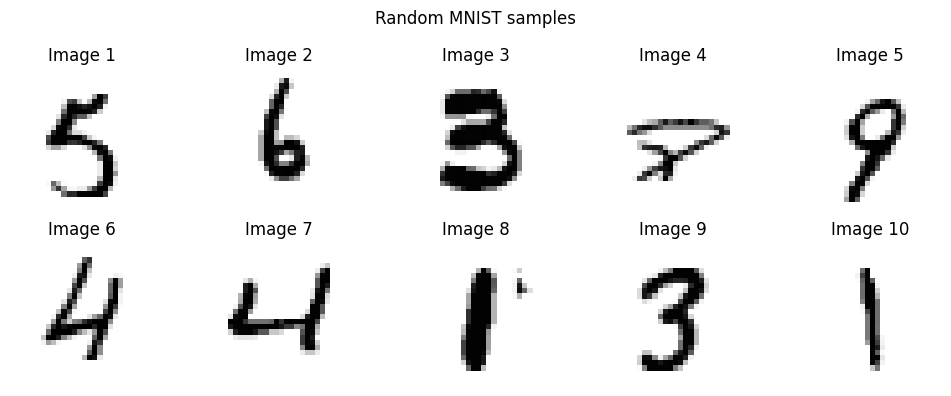

In [8]:
# Randomly sample 10 images from the dataset
indices = torch.randint(0, images.shape[0], (10,))
samples = images[indices]

# Plot the images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(samples[i, 0], cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.suptitle("Random MNIST samples")
plt.tight_layout()
plt.show()

## 3. Forward SDE – Contractive Ornstein–Uhlenbeck (COU)

We now use the **Contractive OU (COU)** process as our forward SDE. This model is inspired by the classical Ornstein–Uhlenbeck dynamics, but with the opposite drift direction. It is defined by:

$$
f(t, x) = \theta(x - \mu), \quad g(t) = \sigma > 0
$$

where

$$
\theta > 0, \quad \mu \in \mathbb{R}^d, \quad \sigma \in \mathbb{R}_+
$$

This forward process leads to the following choice for the noise distribution:

$$
p_{\text{noise}}(\cdot) = \mathcal{N}\left(0, \ \frac{\sigma^2}{2\theta}(e^{2\theta T} - 1) I \right)
$$

The corresponding reverse SDE is:

$$
dY_t = \left(-\theta(Y_t - \mu) + \sigma^2 \nabla \log p(T - t, Y_t)\right) dt + \sigma \, d\bar{B}_t
$$

with initial condition

$$
Y_0 \sim p_{\text{noise}}(\cdot)
$$

In [12]:
# Parameters for the Contractive Ornstein–Uhlenbeck (COU) SDE
size = 28              # Image size (28x28 for MNIST)
T = 1.0                # Final time of the diffusion process
N = 10_000             # Number of discretization steps
delta = T / N          # Time step

theta = 0.2           # Drift intensity (controls contraction speed)
sigma = 1.0            # Constant diffusion level
mu = 0.0               # Center of contraction (mean image, here set to 0)

# These parameters were selected heuristically they were not fine-tuned but provided reasonable empirical behavior.

def f_COU(t, x):
    """Drift term of the COU SDE: f(t, x) = theta * (x - mu)"""
    return theta * (x - mu)

def g_COU(t):
    """Diffusion term of the COU SDE: constant sigma"""
    return sigma

## 4. Forward Process Simulation and Visualization

We now simulate the forward diffusion defined by the COU SDE, starting from a clean MNIST image.

As before, we use the Euler–Maruyama scheme to approximate the continuous-time process. The function below shows the progressive corruption of a single image over time.

In [13]:
def sde_forward_COU(x0, steps=10):
    """
    Simulate the forward process of the COU SDE and display its evolution over time.

    Args:
        x0 (torch.Tensor): Initial image tensor of shape (1, size, size)
        steps (int): Number of time steps to visualize (default: 10)
    """
    xi = x0.clone()
    fig, axes = plt.subplots(1, steps + 1, figsize=(steps * 2.2, 2.5))

    # Select time indices for visualization
    times_to_show = torch.linspace(0, T, steps + 1)
    show_indices = [int(t.item() / delta) for t in times_to_show]

    idx_display = 0
    for i in range(N + 1):
        t = i * delta
        noise = torch.randn_like(xi)

        # Euler–Maruyama update: x ← x + f(t,x)·dt + g(t)·√dt·ε
        xi = xi + delta * f_COU(t, xi) + g_COU(t) * noise * np.sqrt(delta)

        # Display selected time steps
        if i == show_indices[idx_display]:
            img = xi[0].detach().cpu().numpy()
            axes[idx_display].imshow(img, cmap='gray')
            axes[idx_display].axis('off')
            axes[idx_display].set_title(f"t = {t:.2f}")
            idx_display += 1

    plt.suptitle("COU SDE – Forward Process", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

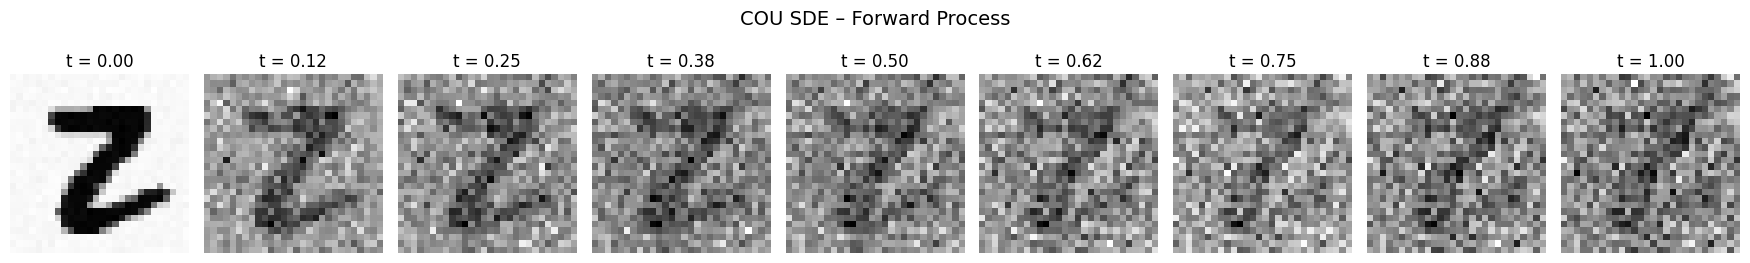

In [16]:
# Select a random image from the dataset
idx = np.random.randint(0, len(images))
sample = images[idx]

# Simulate and visualize the forward process
sde_forward_COU(sample, steps=8)

## 5. Score Network and Training

### 5.1 U-Net Architecture for the Score Model

As in the previous notebook, we use a neural network to approximate the time-dependent score function $ \nabla \log p_t(x) $, which drives the reverse-time denoising process.

We again adopt a **U-Net** architecture, well-suited for image data due to its encoder–decoder structure with skip connections. This design enables the model to retain both local and global spatial information, which is essential for reconstructing complex visual patterns.

The time variable $ t $ is also concatenated as an extra input channel to each image, allowing the model to condition its predictions on the current noise level.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScoreNetUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the encoder (downsampling path)
        def down_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )

        # Define the decoder (upsampling path)
        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )

        # U-Net layers
        self.down1 = down_block(2, 64)      # Input: (x, t) → 64 channels
        self.down2 = down_block(64, 128)    # Downsample → 128 channels
        self.down3 = down_block(128, 256)   # Downsample → 256 channels
        self.pool = nn.MaxPool2d(2)         # Max pooling (stride 2)

        self.middle = down_block(256, 512)  # Bottleneck

     
        self.up1 = up_block(512 + 256, 256)  # Upsample + skip from down3
        self.up2 = up_block(256 + 128, 128)  # Upsample + skip from down2
        self.up3 = up_block(128 + 64, 64)    # Upsample + skip from down1

        # Final output layer: 1 channel (score estimate)
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, t, x):
        """
        Forward pass through the U-Net score model.

        Args:
            t (torch.Tensor): Time tensor of shape (B,) or (B, 1)
            x (torch.Tensor): Noisy input image of shape (B, 1, H, W)

        Returns:
            torch.Tensor: Predicted score ∇ log p_t(x) of shape (B, 1, H, W)
        """
        B, _, H, W = x.shape

        # Broadcast t to shape (B, 1, H, W) and concatenate with x
        t = t.view(B, 1, 1, 1).expand(B, 1, H, W)
        xt = torch.cat([x, t], dim=1)  # Shape: (B, 2, 28, 28)

        # Encoder path
        d1 = self.down1(xt)               # (B, 64, 28, 28)
        d2 = self.down2(self.pool(d1))    # (B, 128, 14, 14)
        d3 = self.down3(self.pool(d2))    # (B, 256, 7, 7)

        # Bottleneck
        mid = self.middle(d3)             # (B, 512, 7, 7)

        # Decoder path with skip connections
        up1 = F.interpolate(mid, size=d3.shape[2:], mode='bilinear', align_corners=False)
        up1 = self.up1(torch.cat([up1, d3], dim=1))  # (B, 256, 7, 7)

        up2 = F.interpolate(up1, size=d2.shape[2:], mode='bilinear', align_corners=False)
        up2 = self.up2(torch.cat([up2, d2], dim=1))  # (B, 128, 14, 14)

        up3 = F.interpolate(up2, size=d1.shape[2:], mode='bilinear', align_corners=False)
        up3 = self.up3(torch.cat([up3, d1], dim=1))  # (B, 64, 28, 28)

        # Output layer
        return self.out_conv(up3)         # (B, 1, 28, 28)

## 5.2 Conditional Mean and Variance for the Forward COU Process

As previously seen, to compute the loss during training, we need the analytical expression of the distribution $ p_t(x \mid x_0) $ induced by the forward SDE.

For the **Contractive Ornstein–Uhlenbeck (COU)** process defined by:

$$
dX_t = \theta (X_t - \mu)\, dt + \sigma\, dB_t,
$$

with initial condition $ X_0 = x_0 $, the marginal distribution $ p_t(x \mid x_0) $ is Gaussian and admits a closed-form expression for its mean and variance.

### Conditional Mean

The conditional expectation is given by:

$$
\mathbb{E}[X_t \mid X_0 = x_0] = \mu + e^{\theta t} (x_0 - \mu)
$$

This can be derived by defining $ Z_t = X_t - \mu $, which satisfies the linear SDE:

$$
dZ_t = \theta Z_t\, dt + \sigma\, dB_t
$$

The solution to this equation is:

$$
Z_t = e^{\theta t} Z_0 + \sigma \int_0^t e^{\theta(t - s)}\, dB_s
$$

Taking expectations:

$$
\mathbb{E}[Z_t] = e^{\theta t} Z_0 = e^{\theta t}(x_0 - \mu)
\quad \Rightarrow \quad
\mathbb{E}[X_t] = \mu + e^{\theta t}(x_0 - \mu)
$$

### Conditional Variance

The variance of the process is given by:

$$
\mathrm{Var}(X_t \mid X_0 = x_0) = \frac{\sigma^2}{2\theta} \left(e^{2\theta t} - 1\right)
$$

This is obtained from the stochastic integral part:

$$
\mathrm{Var}\left( \sigma \int_0^t e^{\theta(t - s)}\, dB_s \right)
= \sigma^2 \int_0^t e^{2\theta(t - s)}\, ds = \frac{\sigma^2}{2\theta} \left(e^{2\theta t} - 1\right)
$$

### Conclusion

We can therefore write the conditional distribution as:

$$
X_t \mid X_0 = x_0 \sim \mathcal{N} \left( \mu + e^{\theta t} (x_0 - \mu), \ \frac{\sigma^2}{2\theta} (e^{2\theta t} - 1) \right)
$$

These closed-form expressions will be used in the **denoising score matching loss**.

In [20]:
def mu_cou(t, x0):
    """Conditional mean of X_t given X_0 under the COU SDE."""
    return mu + torch.exp(theta * t).view(-1, 1, 1, 1) * (x0 - mu)

def sigma_cou(t):
    """Conditional standard deviation of X_t given X_0 under the COU SDE."""
    return torch.sqrt((sigma ** 2) / (2 * theta) * (torch.exp(2 * theta * t) - 1)).view(-1, 1, 1, 1)

### 5.3 Denoising Score Matching Loss under COU

To train the score network, we use the **Denoising Score Matching (DSM)** objective, adapted to the Contractive Ornstein–Uhlenbeck (COU) process.

Given that the forward marginal $ X_t \mid X_0 = x_0 $ follows a Gaussian distribution:

$$
X_t \sim \mathcal{N}(\mu(t, x_0), \sigma^2(t) I),
$$

we can reparameterize it as:

$$
x_t = \mu(t, x_0) + \sigma(t) \cdot \varepsilon, 
\quad 
\varepsilon \sim \mathcal{N}(0, I).
$$

The DSM loss then takes the form:

$$
\mathcal{L}_{\text{DSM}} = 
\mathbb{E}_{t, x_0, \varepsilon} 
\left[ 
\left\| 
\sigma(t) \cdot s_\theta(t, x_t) + \varepsilon 
\right\|^2 
\right].
$$

This loss is implemented in the `dsm_loss_cou` function below.

In [21]:
def dsm_loss_cou(score_model, x0s, T):
    """
    Compute the denoising score matching loss under the COU SDE.

    Args:
        score_model: neural network approximating the score function
        x0s (torch.Tensor): batch of clean data samples
        T (float): final time of the diffusion process
    """
    B = x0s.shape[0]
    device = x0s.device
    t = torch.rand(B, device=device) * T  # sample random times
    eps = torch.randn_like(x0s)           # Gaussian noise
    x_t = mu_cou(t, x0s) + sigma_cou(t)  * eps  # sample X_t | X_0

    score_pred = score_model(t, x_t)
    loss = ((sigma_t * score_pred + eps) ** 2).mean()  # DSM loss
    return loss

### 5.3 — Unified Training Setup: Checkpoints, Skipping and Hugging Face

As previously seen, this block defines a flexible training setup that adapts to different scenarios. Depending on your needs, you can:
- **Resume** training from a local checkpoint if available;
- **Start** training from scratch if no saved model is found;
- **Skip** training entirely (e.g., for sampling only);
- **Load** a pretrained model directly from the Hugging Face Hub.

To bypass training, simply set `skip_training = True`.  
You can also use the `use_huggingface` flag to fetch a model trained elsewhere and proceed directly to sampling.

In [22]:
import os
from huggingface_hub import hf_hub_download

# ===== Options =====
use_huggingface = True   # Set to True to load model from Hugging Face
skip_training = False    # Set to True to skip training

# ===== Setup: Model, Optimizer, Scheduler =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
score_model = ScoreNetUNet().to(device)
optimizer = torch.optim.Adam(score_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)

# ===== Load Model =====
checkpoint_path = "checkpoint.pth"
start_step = 0

if use_huggingface:
    print("Loading checkpoint from Hugging Face Hub...")
    model_path = hf_hub_download(
        repo_id="Arsenecl/diffusion_model",
        filename="score_based_mnist_cou_model",  # <- Change later for COU if needed
        
    )
    checkpoint = torch.load(model_path, map_location=device)
    score_model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_step = checkpoint.get('step', 0)
    print(f"Checkpoint loaded from Hugging Face at step {start_step}.")
elif os.path.exists(checkpoint_path):
    print("Local checkpoint found. Resuming training...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    score_model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_step = checkpoint.get('step', 0)
    print(f"Training resumed from step {start_step}.")
else:
    print("No checkpoint found. Starting training from scratch.")

# ===== Skip Training Option =====
if skip_training:
    print("Training is skipped.")
else:
    print("Training will proceed.")

Loading checkpoint from Hugging Face Hub...


score_based_mnist_cou_model:   0%|          | 0.00/93.6M [00:00<?, ?B/s]

Checkpoint loaded from Hugging Face at step 100000.
Training will proceed.


### 5.4 — Training Loop

We now run the training loop using the Denoising Score Matching (DSM) objective.

At each step:
- A random batch of images is sampled.
- The model predicts the score $ s_\theta(t, x) $, and the DSM loss is computed.
- A gradient descent update is performed.
- A learning rate scheduler gradually reduces the step size.

Every 1000 steps, the model and optimizer states are saved.
The final model is saved at the end of training.

In [50]:
batch_size = 64
num_steps = start_step + 20000  # Number of training steps to run

images = images.to(device)

for step in tqdm(range(start_step, num_steps)):
    # Sample a random batch of images
    batch_idx = torch.randint(0, len(images), (batch_size,))
    x0s = images[batch_idx]

    # Compute the denoising score matching loss 
    loss = dsm_loss_cou(score_model, x0s, T)

    # Gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Save checkpoint every 1000 steps
    if step % 1000 == 0:
        print(f"[{step}] DSM loss: {loss.item():.4f}")
        torch.save({
            'model': score_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'step': step
        }, checkpoint_path)

# Save final checkpoint at the end of training
print(f"[{num_steps}] Final model saved.")
torch.save({
    'model': score_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'step': num_steps
}, checkpoint_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

[100000] DSM loss: 0.1747


 50%|████▉     | 499/1000 [00:20<00:20, 24.91it/s]

[100500] DSM loss: 0.0657


100%|██████████| 1000/1000 [00:40<00:00, 24.61it/s]


[101000] Final model saved.


## 6 — Visualizing Sample Quality with the Reverse Process

To evaluate the quality of the samples generated by our trained score model, we implement a reverse-time SDE sampler using the **predictor-corrector scheme**. This approach combines:

- A predictor step, based on the Euler–Maruyama discretization of the time-reversed COU SD*, which ensures the global trajectory follows the learned score.
- A corrector step, based on Langevin MCMC, which locally refines the sample to better match the target distribution at each time step.

The reverse process is initialized from the marginal distribution : 
$$
X_T \sim \mathcal{N}\left(0, \ \frac{\sigma^2}{2\theta}(e^{2\theta T} - 1) \cdot I\right)
$$

This method typically yields sharper results than a pure predictor-only scheme. Below, we generate visualizations of intermediate steps during the reverse process, starting from Gaussian noise and progressively denoising the sample.

In [29]:
def run_reverse_sde_pc_cou(score_model, shape=(1, 1, 28, 28), n_corrector=1, langevin_step_size=0.002, steps=8):
    """
    Run the predictor-corrector sampler for the reverse COU SDE.

    Args:
        score_model: Trained neural network approximating the score function
        shape (tuple): Shape of the output sample (e.g. (1, 1, 28, 28) for MNIST)
        n_corrector (int): Number of Langevin corrector steps per time step
        langevin_step_size (float): Step size for Langevin MCMC
        steps (int): Number of images to display during sampling
    """
    score_model.eval()
    with torch.no_grad():
        N_steps = 1000
        delta_t = T / N_steps

        # Initial sample from Gaussian noise with same variance as final forward distribution
        std_init = torch.sqrt(torch.tensor((sigma**2) / (2 * theta) * (np.exp(2 * theta * T) - 1), device=device))
        x = torch.randn(shape).to(device) * std_init 

        # Create figure with one subplot per snapshot
        fig, axes = plt.subplots(1, steps + 1, figsize=(steps * 2, 4))

        for j in range(N_steps+1):
            # Current time (decreasing from T to 0)
            t = T - j * delta_t
            t_tensor = torch.full((shape[0],), t, device=device)
            
            # Get theta and sigma(t) for this time step
            theta_tensor = torch.tensor(theta, device=device).view(1, 1, 1, 1)
            sigma_t = sigma_cou(t_tensor).view(-1, 1, 1, 1)


            # Predictor step
            score = score_model(t_tensor, x)
            noise = torch.randn_like(x)
            drift = theta_tensor * (x - mu) - (sigma_t ** 2) * score
            diffusion = sigma_t * noise * np.sqrt(delta_t)
            x = x + drift * delta_t + diffusion

            # Corrector step
            for _ in range(n_corrector):
                score = score_model(t_tensor, x)
                noise = torch.randn_like(x)
                x = x + langevin_step_size * score + torch.sqrt(torch.tensor(2 * langevin_step_size)) * noise
                
            # Save intermediate image 
            if j % (N_steps // steps) == 0:
                idx = j // (N_steps // steps)
                img = x[0, 0].cpu().numpy()
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(f"t={t:.2f}")
                axes[idx].axis('off')

        plt.suptitle("Reverse Process with COU SDE (Predictor–Corrector)")
        plt.show()

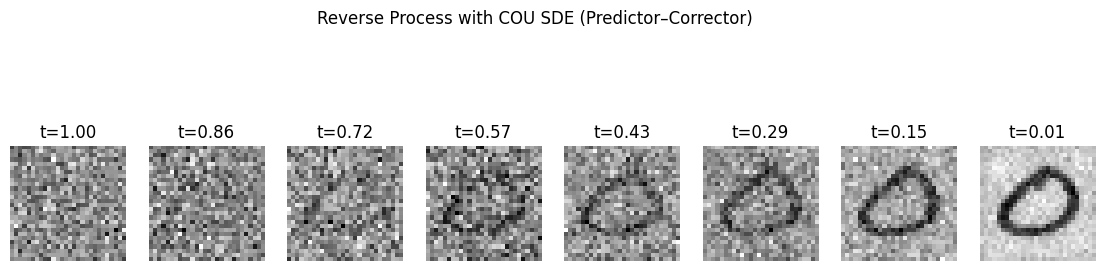

In [30]:
run_reverse_sde_pc_cou(score_model=score_model, n_corrector=3, langevin_step_size=0.002,steps=7)

## 7 — Conclusion and Next Steps

In this notebook, we implemented a generative model based on a Contractive Ornstein–Uhlenbeck (COU SDE, trained via denoising score matching and evaluated its performance on the MNIST dataset. The key steps included:

- Sampling from the forward SDE and computing the conditional distributions analytically,
- Training a time-conditional score network using a U-Net architecture,
- Reconstructing data samples through a reverse-time SDE using a predictor–corrector method.

Despite its simplicity, this framework demonstrates the core mechanisms of **score-based diffusion models**, and how their dynamics can be adapted to different SDEs like the COU process.

### Limitations and Future Work

Several directions remain to be explored:

- **Evaluation metrics**: Visual inspection is not sufficient. Quantitative metrics (FID, IS) should be added to better assess the generative quality.
- **Dataset complexity**: MNIST is a low-dimensional toy dataset. Extending to more complex datasets (CIFAR-10, CelebA) would test the robustness of the approach.
- **SDE comparison**: It would be useful to compare the COU-based model to other SDEs like VP, VE or sub-VP under identical conditions.

This experiment provides a foundation for exploring richer generative modeling frameworks based on stochastic differential equations, and invites further analysis on their theoretical and empirical behaviors.